# DeepWalk


This code delegates to DeepLearning4j's DeepWalk implementation.

First up let's import some things...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import pandas as pd
from neo4j.v1 import GraphDatabase
import tensorflow as tf


# load data
from sklearn.preprocessing import StandardScaler

In [2]:
driver = GraphDatabase.driver("bolt://localhost", auth=("neo4j", "neo"))

Time to load our data into Neo4j.

In [3]:
edge_list_file = "https://github.com/meltzerpete/Embedding-Vis/raw/master/emails/emails.edgelist"
labels_file = "https://github.com/meltzerpete/Embedding-Vis/raw/master/emails/emails.labels"
attributes_file = None

with driver.session() as session:
    session.run("CREATE CONSTRAINT ON (n:Node) ASSERT n.id IS UNIQUE")
    
    result = session.run("""\
        LOAD CSV FROM $edgelistFile AS row
        FIELDTERMINATOR " "
        MERGE (e1:Node {id: row[0]})
        MERGE (e2:Node {id: row[1]})
        MERGE (e1)-[:LINK]->(e2)
        """, {"edgelistFile": edge_list_file})
    print(result.summary().counters)

    result = session.run("""\
        LOAD CSV FROM $labelsFile AS row
        FIELDTERMINATOR " "
        MATCH (e:Node {id: row[0]})
        SET  e.label = toInteger(row[1])-1
        """, {"labelsFile": labels_file})
    print(result.summary().counters)

    if attributes_file is not None:
        result = session.run("""\
            load csv from $attributesFile  as row
            FIELDTERMINATOR " "
            with toString(toInteger(row[0])) AS nodeId, row[1..] AS properties
            MATCH (s:Node {id: nodeId})
            WITH s, properties
            UNWIND range(0, size(properties)-1) AS index
            CALL apoc.create.setProperty(s, "property_" + index, toFloat(properties[index])) YIELD node
            return count(*)
            """, {"attributesFile": attributes_file})
        print(result.summary().counters)

{}
{'properties_set': 1005}


In [4]:
embedding_property_name = "deepwalk_embedding"
vector_size = 64
learning_rate = 0.025
window_size = 5
walk_length = 40
number_of_walks = 15

In [5]:
with driver.session() as session:
    params = {
        "writeProperty": embedding_property_name,
        "vectorSize": vector_size,
        "learningRate": learning_rate,
        "windowSize": window_size,
        "walkSize": walk_length,
        "numberOfWalks": number_of_walks
    }
    result = session.run("""
    call
    algo.deepWalk(
        null,
        null,
        
        {vectorSize: $vectorSize,
         windowSize: $windowSize,
         walkSize: $walkSize,
         learningRate: $learningRate,
         numberOfWalks: $numberOfWalks,
         writeProperty: $writeProperty})
    """, params)
    print(result.peek())

<Record nodes=1005 iterations=0 loadMillis=-1 computeMillis=-1 writeMillis=42 dampingFactor=0.0 write=False writeProperty=None>


In [6]:
with driver.session() as session:
    result = session.run("""\
    MATCH (n) 
    WITH n.label as class, count(*) AS c
    ORDER BY c DESC
    WITH class WHERE c > 50
    WITH class ORDER BY class
    with collect(class) AS biggestClasses
    MATCH (p:Node) WHERE p.label IN biggestClasses
    SET p.mlLabel = apoc.coll.indexOf(biggestClasses, p.label)
    """)

In [7]:
with driver.session() as session:
    result = session.run("""\
    MATCH (n) 
    WITH n.label as class, count(*) AS c
    ORDER BY c DESC
    WITH class WHERE c > 50
    WITH class ORDER BY class
    with collect(class) AS biggestClasses
    MATCH (p:Node) WHERE p.label IN biggestClasses
    RETURN p.`%s` AS embedding, apoc.coll.indexOf(biggestClasses, p.label) AS label, p.label as initialLabel
    ORDER BY label
    """ % embedding_property_name)

    df = pd.DataFrame(dict(row) for row in result)

emb = df["embedding"].apply(pd.Series).values
labels = df["label"].values

/home/markhneedham/projects/Embedding-Vis/a/local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


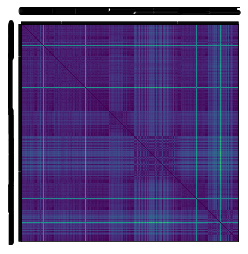

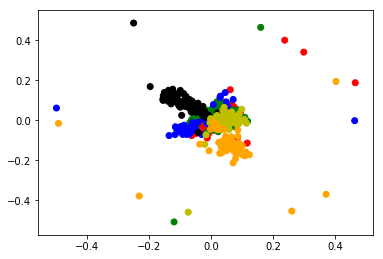

In [8]:
# Heatmap
colours = ['r', 'g', 'b', 'black', 'y', 'orange']
cols = pd.DataFrame(labels).apply(lambda x: colours[int(x)], axis=1).values

dist = np.ndarray([len(emb), len(emb)])

for i, e1 in enumerate(emb):
    for j, e2 in enumerate(emb):
        dist.itemset((i, j), np.linalg.norm(e1 - e2, 2))

plt.imshow(dist)
plt.axes().xaxis.tick_top()
plt.xticks(np.arange(len(dist)), labels)
plt.yticks(np.arange(len(dist)), labels)
plt.show()

# 2D Visualisation
# from: https://baoilleach.blogspot.com/2014/01/convert-distance-matrix-to-2d.html
adist = dist
amax = np.amax(adist)
adist /= amax

mds = manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=6)
results = mds.fit(adist)

coords = results.embedding_

plt.subplots_adjust(bottom=0.1)
plt.scatter(
    coords[:, 0], coords[:, 1], marker='o', c=cols
)

plt.show()

In [9]:
X = pd.DataFrame(emb)
y = labels

X = StandardScaler().fit_transform(X)
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=.4, random_state=42)

clf = MLPClassifier(solver='sgd',
                    activation='tanh',
                    learning_rate_init=0.001,
                    alpha=1e-5,
                    hidden_layer_sizes=(30, 30),
                    max_iter=10000,
                    batch_size=X.shape[0],
                    random_state=0)

clf.n_outputs_ = 6
clf.out_activation_ = "softmax"
print(clf.get_params())
clf.fit(train_x, train_y)

mean_acc = clf.score(test_x, test_y)
print(mean_acc)

{'beta_1': 0.9, 'warm_start': False, 'beta_2': 0.999, 'shuffle': True, 'verbose': False, 'nesterovs_momentum': True, 'hidden_layer_sizes': (30, 30), 'epsilon': 1e-08, 'activation': 'tanh', 'max_iter': 10000, 'batch_size': 433, 'power_t': 0.5, 'random_state': 0, 'learning_rate_init': 0.001, 'tol': 0.0001, 'validation_fraction': 0.1, 'alpha': 1e-05, 'solver': 'sgd', 'momentum': 0.9, 'learning_rate': 'constant', 'early_stopping': False}


/home/markhneedham/projects/Embedding-Vis/a/local/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:358: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


0.7931034482758621


In [10]:
with driver.session() as session:
    result = session.run("""\
    MATCH (n:Node) 
    WITH n.label as class, count(*) AS c
    ORDER BY c DESC
    WITH class WHERE c > 50 
    with collect(class) AS biggestClasses
    MATCH (n:Node) WHERE n.label IN biggestClasses
    RETURN n.%s AS embedding, n.mlLabel AS label, id(n) AS nodeId
    """ %(embedding_property_name))
    
    for row in result:
        prediction = clf.predict(np.array([row["embedding"]]))[0]
        params = {"nodeId": row["nodeId"], "prediction": int(prediction)}
        session.run("""\
        MATCH (n) WHERE id(n) = toInteger($nodeId)
        SET n.prediction = $prediction
        """, params)


In [11]:
with driver.session() as session:
    result = session.run("""\
    MATCH (n) 
    WHERE exists(n.mlLabel)
    RETURN n.mlLabel = n.prediction AS correct, count(*) AS count
    """)
    for row in result:
        print(row)

<Record correct=False count=182>
<Record correct=True count=251>


In [12]:
learning_rate = 0.1
num_steps = 1000
batch_size = 128
display_step = 100

n_hidden_1 = 30 # 1st layer number of neurons
n_hidden_2 = 30 # 2nd layer number of neurons
num_input = 18 
num_classes = 8 

def neural_net(x_dict):
    x = x_dict['emb']
    layer_1 = tf.layers.dense(x, n_hidden_1, activation=tf.nn.tanh)
    layer_2 = tf.layers.dense(layer_1, n_hidden_2, activation=tf.nn.tanh)
    out_layer = tf.layers.dense(layer_2, num_classes)
    return out_layer


def model_fn(features, labels, mode):
    logits = neural_net(features)

    pred_classes = tf.argmax(logits, axis=1)
    pred_probas = tf.nn.softmax(logits)

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes)

    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())

    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)

    estim_specs = tf.estimator.EstimatorSpec(
        mode=mode,
        predictions=pred_classes,
        loss=loss_op,
        train_op=train_op,
        eval_metric_ops={'accuracy': acc_op})

    return estim_specs

In [13]:
emb = StandardScaler().fit_transform(emb)

X_train, X_test, y_train, y_test = train_test_split(emb, labels, test_size=0.33, random_state=42)

In [14]:
model = tf.estimator.Estimator(model_fn)

input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'emb': X_train}, y=y_train,
    batch_size=batch_size, num_epochs=None, shuffle=True)

model.train(input_fn, steps=num_steps)

input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'emb': X_test}, y=y_test,
    batch_size=batch_size, shuffle=True)

e = model.evaluate(input_fn)

print("Testing Accuracy:", e['accuracy'])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f672de89f90>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_device_fn': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/tmp/tmpNkWtYg', '_train_distribute': None, '_save_summary_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpNkWtYg/model.ckpt.
INFO:tensorf